In [2]:
#Exploration of New product - September 2021
#Section with PCs and with Levels
import datetime as dt 
import glob
import netCDF4 as nc
import numpy as np
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cmocean
import gsw

import yaml

import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import xarray as xr
import numpy as np
import pandas as pd



import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config["data_dir"] = './cartopy_shapefiles'

os.getcwd()
pathMon = '/home/datawork-lops-bluecloud/osnet/grilled_Nordic_Sea/'
pathfig = '/home/datawork-lops-bluecloud/osnet/grilled_Nordic_Sea/figures/'

In [3]:
with open(r'configuration.yaml') as file:
    configuration = yaml.load(file, Loader=yaml.FullLoader)

    print("File version: ", configuration["version"])

File version:  0.1


### View Grilled product

In [4]:
%%time
#Plot section with longitude fixed
#Test on the product for 2016 January 01
t = '1993-01-01'
yy = t[0:4]
mm = t[5:7]
dd = t[8:10]

ds = xr.open_dataset(pathMon + "produit_199301.nc")
ds.load()

CPU times: user 36 ms, sys: 96 ms, total: 132 ms
Wall time: 570 ms


<xarray.Dataset>
Dimensions:             (time: 31, lat: 32, lon: 100, DEPTH: 51)
Coordinates:
    mask                (time, lat, lon) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
  * DEPTH               (DEPTH) int64 0 1 2 3 4 5 6 ... 628 697 773 857 950 1000
  * time                (time) datetime64[ns] 1993-01-01 ... 1993-01-31
  * lat                 (lat) float64 69.12 69.38 69.62 ... 76.38 76.62 76.88
  * lon                 (lon) float64 -19.88 -19.62 -19.38 ... 4.375 4.625 4.875
Data variables: (12/17)
    SLA                 (time, lat, lon) float32 -0.031 -0.0286 ... -0.0605
    UGOS                (time, lat, lon) float32 -0.0263 -0.0258 ... -0.0129
    VGOS                (time, lat, lon) float32 -0.0532 -0.0446 ... 0.072
    UGOSA               (time, lat, lon) float32 -0.0074 -0.0102 ... -0.0056
    VGOSA               (time, lat, lon) float32 0.0165 0.0184 ... 0.0491 0.0496
    SLA_err             (time, lat, lon) float32 0.0129 0.0127 ... 0.0176 0.0167
    ...                  ...
    PSAL_predicted      (DEPTH, time, lat, lon) float32 34.76 34.8 ... 34.9 34.9
    TEMP_predicted      (DEPTH, time, lat, lon) float32 0.1063 ... -0.5864
    PSAL_predicted_std  (DEPTH, time, lat, lon) float32 0.04211 ... 0.006354
    TEMP_predicted_std  (DEPTH, time, lat, lon) float32 0.1602 0.1484 ... 0.1469
    MLD_mask            (DEPTH, time, lat, lon) float32 2.49e-07 ... 0.8107
    SIG_predicted       (DEPTH, time, lat, lon) float64 27.91 27.93 ... 28.06

In [5]:
#Map of TS
proj=ccrs.NorthPolarStereo()
land_feature = cfeature.NaturalEarthFeature(
category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
extent = np.array([12, -20, 65, 80])
subplot_kw = {'projection': proj, 'extent': extent}

#To get the bathymetry
ds_bat = xr.open_dataset(configuration['BATHYMETRIE_output_path'] + configuration['BATHYMETRIE_FILE_NAME'])

ds_bat = ds_bat.where((ds_bat.LONGITUDE>=configuration['longitude1']) & (ds_bat.LONGITUDE<=configuration['longitude2']) & (ds_bat.LATITUDE>=configuration['latitude2']) & 
              (ds_bat.LATITUDE<=configuration['latitude1'])==False,-1500)

kw = {'levels':[-1000], 'colors':['black'],'linewidths':[1],'linestyles':['solid']}

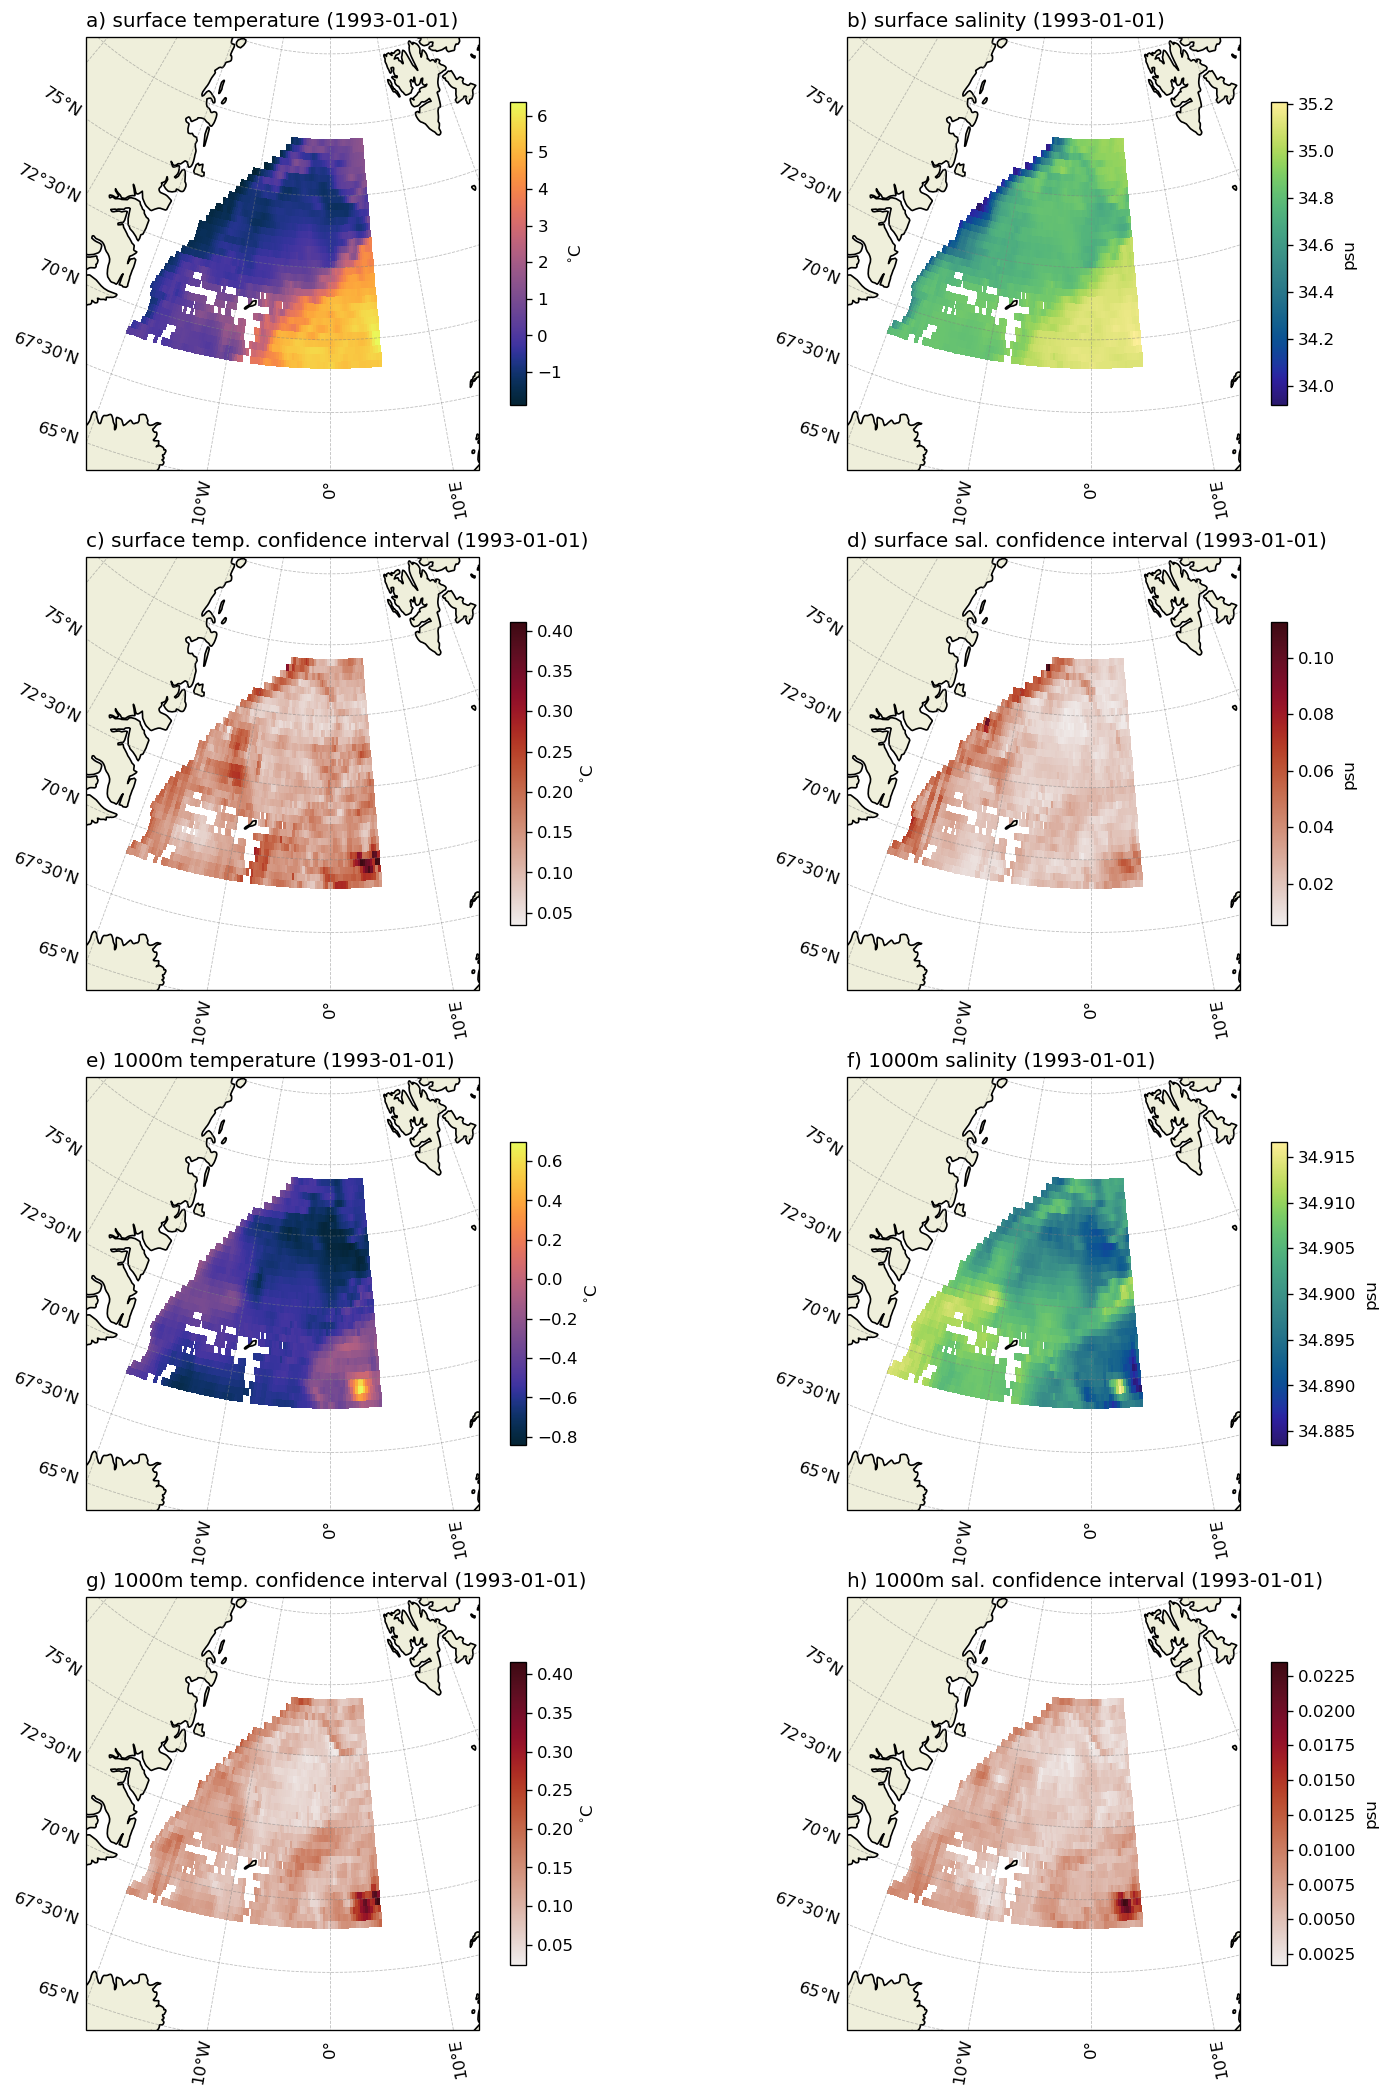

In [6]:
d = 0


subplot_kw = {'projection': proj, 'extent': extent}

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 22), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

for i in [0,2]:
    if i==0:
        d = 0
        ax[i+0,0].set_title('a) surface temperature (' + t + ')',loc = 'left')
        ax[i+0,1].set_title('b) surface salinity (' + t + ')',loc = 'left')
        ax[i+1,0].set_title('c) surface temp. confidence interval (' + t + ')',loc = 'left')
        ax[i+1,1].set_title('d) surface sal. confidence interval (' + t + ')',loc = 'left')
    if i==2:
        d = 1000
        ax[i+0,0].set_title('e) 1000m temperature (' + t + ')',loc = 'left')
        ax[i+0,1].set_title('f) 1000m salinity (' + t + ')',loc = 'left')
        ax[i+1,0].set_title('g) 1000m temp. confidence interval (' + t + ')',loc = 'left')
        ax[i+1,1].set_title('h) 1000m sal. confidence interval (' + t + ')',loc = 'left')
        
    cb = ds['TEMP_predicted'].sel(time = t,DEPTH =  d).plot(ax=ax[i+0,0],center = False,
                  cmap=cmocean.cm.thermal,
                  transform=ccrs.PlateCarree(),
                  cbar_kwargs={"shrink": 0.7,"label":'$^{\circ}$C'})


    ds['PSAL_predicted'].sel(time = t,DEPTH = d).plot(ax=ax[i+0,1],
                  cmap=cmocean.cm.haline,
                  transform=ccrs.PlateCarree(),
                  cbar_kwargs={"shrink": 0.7,"label":
                               'psu'})  
    
    ds['TEMP_predicted_std'].sel(time = t,DEPTH = d).plot(ax=ax[i+1,0],
                  cmap=cmocean.cm.amp,
                  transform=ccrs.PlateCarree(),
                  cbar_kwargs={"shrink": 0.7,"label":'$^{\circ}$C'})
    
    ds['PSAL_predicted_std'].sel(time = t,DEPTH = d).plot(ax=ax[i+1,1],
                  cmap=cmocean.cm.amp,
                  transform=ccrs.PlateCarree(),
                  cbar_kwargs={"shrink": 0.7,"label":'psu'})
    
    
for i in np.arange(4):
    for j in np.arange(2):
        ds_bat['bathymetry'].plot.contour(**kw,ax = ax[i,j])
        ax[i,j].add_feature(land_feature, edgecolor='black')
        gl = ax[i,j].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False

plt.savefig(pathfig + 'TSmap'+str(t)+'.png', transparent=False)
plt.show()

## Plot extract of Glorys12

In [7]:
ds_glorys12 = xr.open_dataset("/home/ref-ocean-reanalysis/global-reanalysis-phy-001-030-daily/1993/01/mercatorglorys12v1_gl12_mean_19930101_R19930106.nc")


In [8]:
ds_glorys12

<xarray.Dataset>
Dimensions:    (longitude: 4320, latitude: 2041, depth: 50, time: 1)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * latitude   (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * time       (time) datetime64[ns] 1993-01-01T12:00:00
Data variables:
    mlotst     (time, latitude, longitude) float32 ...
    zos        (time, latitude, longitude) float32 ...
    bottomT    (time, latitude, longitude) float32 ...
    sithick    (time, latitude, longitude) float32 ...
    siconc     (time, latitude, longitude) float32 ...
    usi        (time, latitude, longitude) float32 ...
    vsi        (time, latitude, longitude) float32 ...
    thetao     (time, depth, latitude, longitude) float32 ...
    so         (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
    vo         (time, depth, latitude, longitude) float32 ...
Attributes: (12/24)
    title:              daily mean fields from Global Ocean Physics Analysis ...
    easting:            longitude
    northing:           latitude
    history:            2017/04/06 14:05:19 MERCATOR OCEAN Netcdf creation
    source:             MERCATOR GLORYS12V1
    institution:        MERCATOR OCEAN
    ...                 ...
    longitude_min:      -180.0
    longitude_max:      179.91667
    latitude_min:       -80.0
    latitude_max:       90.0
    z_min:              0.494025
    z_max:              5727.917

In [ ]:
# convert Absolute temperature to to insitu
p = gsw.p_from_z(ds_glorys12['depth'], ds_glorys12['latitude'])
SA = gsw.SA_from_SP(ds_glorys12['so'], p, ds_glorys12['longitude'], ds_glorys12['latitude'])

CT = gsw.CT_from_pt(SA, ds_glorys12['thetao'])
t = gsw.t_from_CT(SA,CT,p)

print(t)

In [10]:
ds_glorys_selected = ds_glorys12.sel(time=t, depth=0, method='nearest')


ds_glorys_selected_area = ds_glorys_selected.where((ds_glorys_selected['longitude']>=configuration['longitude1']) & (ds_glorys_selected['longitude']<=configuration['longitude2']) & (ds_glorys_selected['latitude']>=configuration['latitude2']) & 
            (ds_glorys_selected['latitude']<=configuration['latitude1']), drop=True)


subplot_kw = {'projection': proj, 'extent': extent}

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 12), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

cb = ds_glorys_selected_area['thetao'].plot(ax=ax[0,0],center = False,
            cmap=cmocean.cm.thermal,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"shrink": 0.7,"label":'$^{\circ}$C'})
ax[0,0].set_title('a) surface temperature (' + t + ')',loc = 'left')

ds_glorys_selected_area['so'].plot(ax=ax[0,1],center = False,
            cmap=cmocean.cm.thermal,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"shrink": 0.7,"label":'psu'})  
ax[0,1].set_title('b) surface salinity (' + t + ')',loc = 'left')

# --------------------------- 1000m ------------------------------------------------

ds_glorys_selected_1000 = ds_glorys12.sel(time=t, depth=1000, method='nearest')

ds_glorys_selected_area_1000 = ds_glorys_selected_1000.where((ds_glorys_selected['longitude']>=configuration['longitude1']) & (ds_glorys_selected['longitude']<=configuration['longitude2']) & (ds_glorys_selected['latitude']>=configuration['latitude2']) & 
            (ds_glorys_selected['latitude']<=configuration['latitude1']), drop=True)

ds_glorys_selected_area_1000['thetao'].plot(ax=ax[1,0],center = False,
            cmap=cmocean.cm.thermal,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"shrink": 0.7,"label":'$^{\circ}$C'})
ax[1,0].set_title('c) 1000m temperature (' + t + ')',loc = 'left')

ds_glorys_selected_area_1000['so'].plot(ax=ax[1,1],center = False,
            cmap=cmocean.cm.thermal,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"shrink": 0.7,"label":'psu'})  
ax[1,1].set_title('d) 1000m salinity (' + t + ')',loc = 'left')


# -------------------------- add bathymetrie ---------------------------------------

for i in np.arange(2):
    for j in np.arange(2):
        ds_bat['bathymetry'].plot.contour(**kw,ax = ax[i,j])
        ax[i,j].add_feature(land_feature, edgecolor='black')
        gl = ax[i,j].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
                
plt.show()

TypeError: Cannot compare dtypes datetime64[ns] and float64

## Plot extract of Armor3D

In [ ]:
ds_Armor3D = xr.open_dataset("/home/ref-cmems-public/tac/multiobs/MULTIOBS_GLO_PHY_REP_015-002/ARMOR3D/data/1993/dataset-armor-3d-rep-weekly_19930106T1200Z_P20190301T0000Z.nc")


In [ ]:
ds_Armor3D

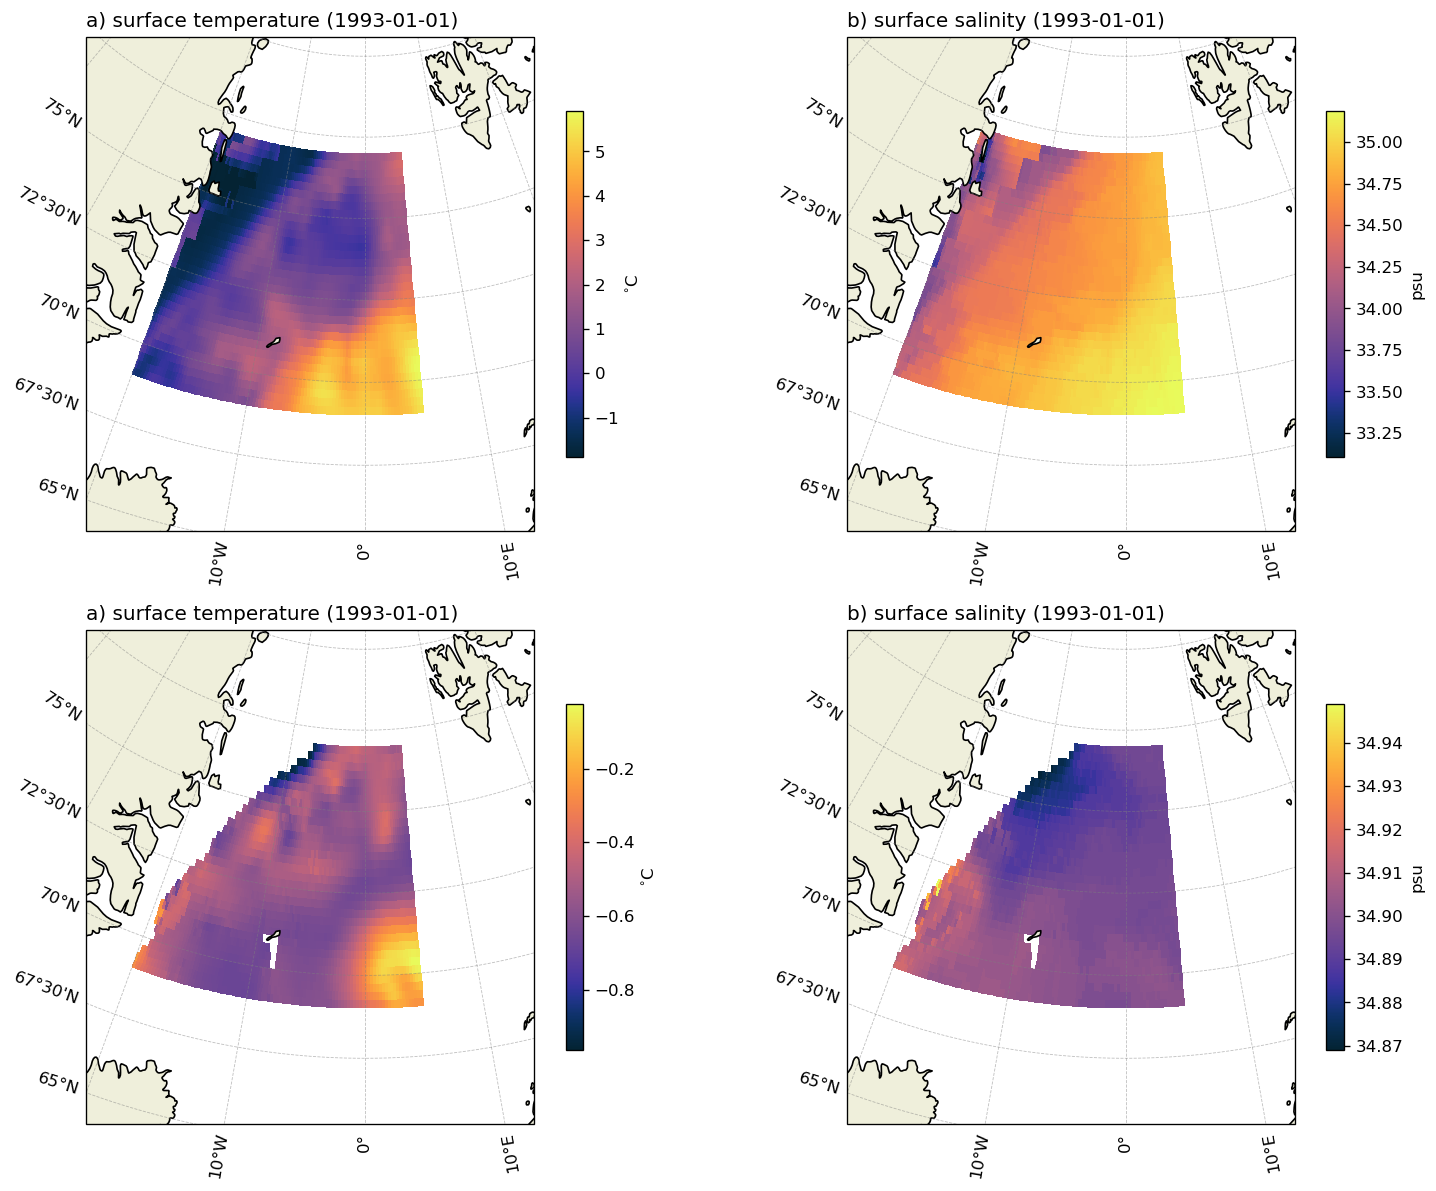

In [11]:
ds_Armor3D_selected = ds_Armor3D.sel(time=t, depth=0, method='nearest')

ds_Armor3D_selected_lon = ds_Armor3D_selected.assign_coords(lon180=(((ds_Armor3D_selected.longitude + 180) % 360) - 180))  
ds_Armor3D_selected_lon['longitude'] = ds_Armor3D_selected_lon.lon180

ds_Armor3D_selected_lon = ds_Armor3D_selected_lon.sortby('longitude')


ds_Armor3D_selected_lon_area = ds_Armor3D_selected_lon.where((ds_Armor3D_selected_lon['longitude']>=configuration['longitude1']) & (ds_Armor3D_selected_lon['longitude']<=configuration['longitude2']) & (ds_Armor3D_selected_lon['latitude']>=configuration['latitude2']) & 
            (ds_Armor3D_selected_lon['latitude']<=configuration['latitude1']), drop=True)

subplot_kw = {'projection': proj, 'extent': extent}

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 12), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

cb = ds_Armor3D_selected_lon_area['to'].plot(ax=ax[0,0],center = False,
            cmap=cmocean.cm.thermal,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"shrink": 0.7,"label":'$^{\circ}$C'})
ax[0,0].set_title('a) surface temperature (' + t + ')',loc = 'left')

ds_Armor3D_selected_lon_area['so'].plot(ax=ax[0,1],center = False,
            cmap=cmocean.cm.thermal,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"shrink": 0.7,"label":'psu'})  
ax[0,1].set_title('b) surface salinity (' + t + ')',loc = 'left')

# --------------------------- 1000m ------------------------------------------------

ds_Armor3D_selected_1000 = ds_Armor3D.sel(time=t, depth=1000, method='nearest')

ds_Armor3D_selected_lon_1000 = ds_Armor3D_selected_1000.assign_coords(lon180=(((ds_Armor3D_selected_1000.longitude + 180) % 360) - 180))  
ds_Armor3D_selected_lon_1000['longitude'] = ds_Armor3D_selected_lon_1000.lon180

ds_Armor3D_selected_lon_1000 = ds_Armor3D_selected_lon_1000.sortby('longitude')


ds_Armor3D_selected_lon_area_1000 = ds_Armor3D_selected_lon_1000.where((ds_Armor3D_selected_lon_1000['longitude']>=configuration['longitude1']) & (ds_Armor3D_selected_lon_1000['longitude']<=configuration['longitude2']) & (ds_Armor3D_selected_lon_1000['latitude']>=configuration['latitude2']) & 
            (ds_Armor3D_selected_lon_1000['latitude']<=configuration['latitude1']), drop=True)


ds_Armor3D_selected_lon_area_1000['to'].plot(ax=ax[1,0],center = False,
            cmap=cmocean.cm.thermal,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"shrink": 0.7,"label":'$^{\circ}$C'})
ax[1,0].set_title('a) surface temperature (' + t + ')',loc = 'left')

ds_Armor3D_selected_lon_area_1000['so'].plot(ax=ax[1,1],center = False,
            cmap=cmocean.cm.thermal,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"shrink": 0.7,"label":'psu'})  
ax[1,1].set_title('b) surface salinity (' + t + ')',loc = 'left')

# -------------------------- add bathymetrie ---------------------------------------

for i in np.arange(2):
    for j in np.arange(2):
        ds_bat['bathymetry'].plot.contour(**kw,ax = ax[i,j])
        ax[i,j].add_feature(land_feature, edgecolor='black')
        gl = ax[i,j].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
                
plt.show()

### Compare results Between Glorys12, Armor3D et OsNet - temperature

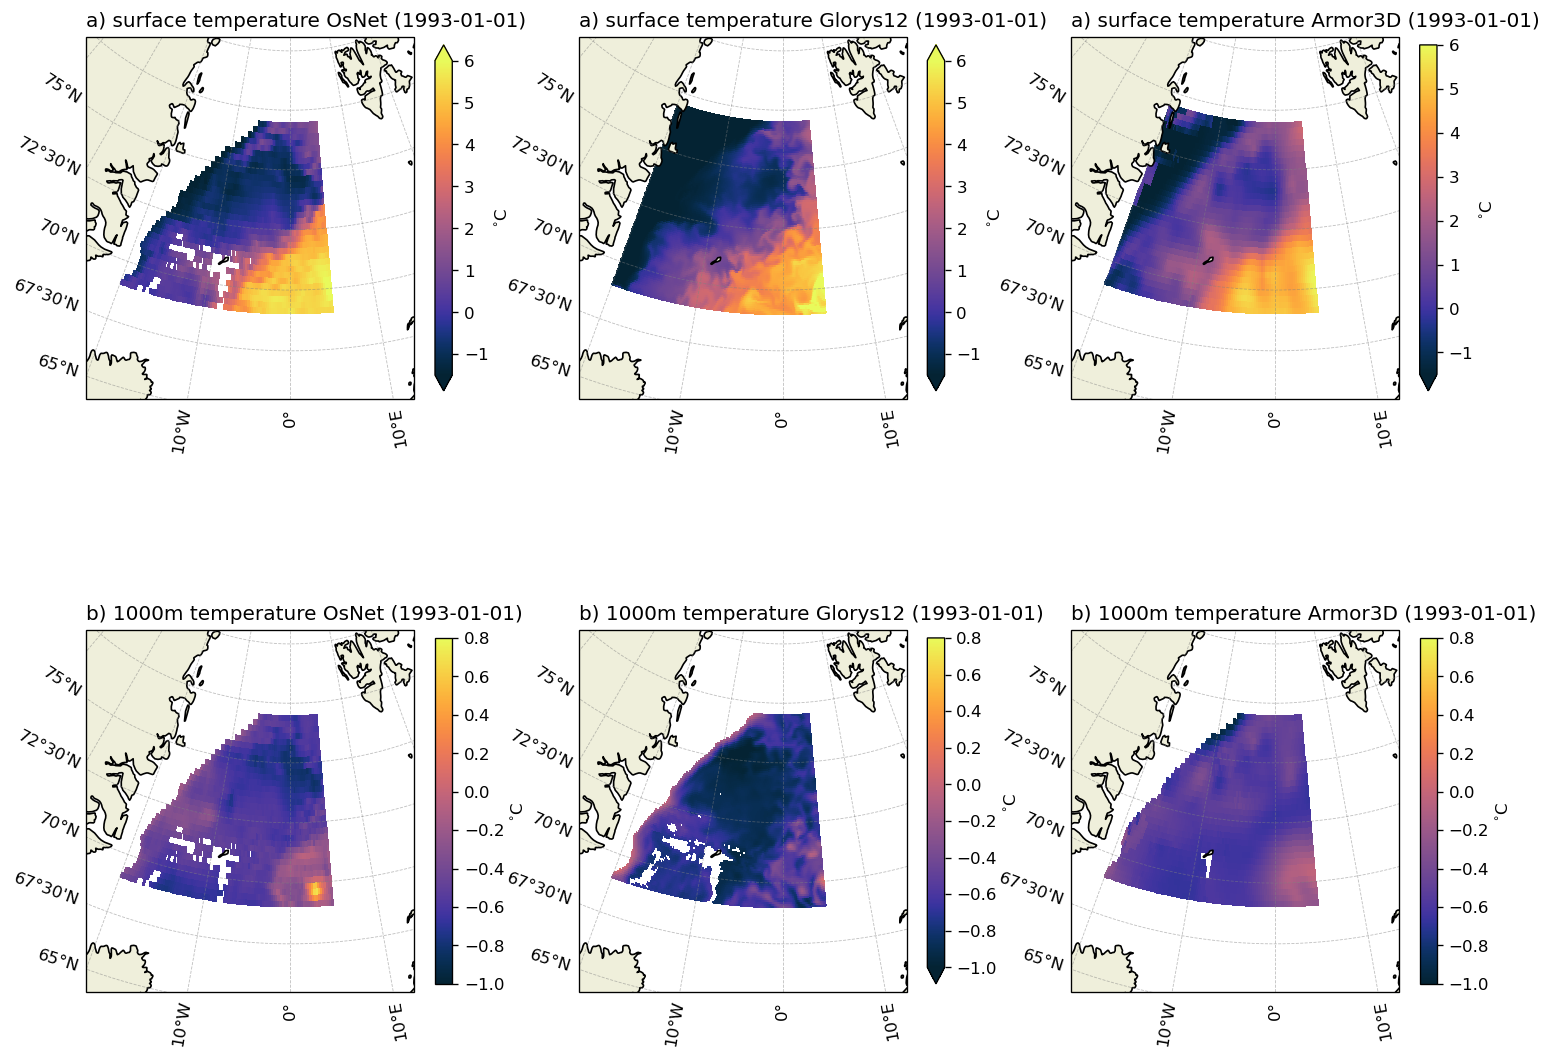

In [16]:
subplot_kw = {'projection': proj, 'extent': extent}

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 12), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)


# ------------------------------- Surface -----------------------


cb = ds['TEMP_predicted'].sel(time = t,DEPTH =  0).plot(ax=ax[0,0],center = False,  vmin=-1.5, vmax = 6,
                  cmap=cmocean.cm.thermal,
                  transform=ccrs.PlateCarree(),
                  cbar_kwargs={"shrink": 0.7,"label":'$^{\circ}$C'})
ax[0,0].set_title('a) surface temperature OsNet (' + t + ')',loc = 'left')

ds_glorys_selected_area['thetao'].plot(ax=ax[0,1],center = False, vmin=-1.5, vmax = 6,
            cmap=cmocean.cm.thermal,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"shrink": 0.7,"label":'$^{\circ}$C'})
ax[0,1].set_title('a) surface temperature Glorys12 (' + t + ')',loc = 'left')

ds_Armor3D_selected_lon_area['to'].plot(ax=ax[0,2],center = False, vmin=-1.5, vmax = 6,
            cmap=cmocean.cm.thermal,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"shrink": 0.7,"label":'$^{\circ}$C'})
ax[0,2].set_title('a) surface temperature Armor3D (' + t + ')',loc = 'left')
        
# ------------------------------- 1000m -----------------------

ds['TEMP_predicted'].sel(time = t,DEPTH =  1000).plot(ax=ax[1,0],center = False, vmin=-1, vmax = 0.8,
                  cmap=cmocean.cm.thermal, 
                  transform=ccrs.PlateCarree(),
                  cbar_kwargs={"shrink": 0.7,"label":'$^{\circ}$C'})
ax[1,0].set_title('b) 1000m temperature OsNet (' + t + ')',loc = 'left')

ds_glorys_selected_area_1000['thetao'].plot(ax=ax[1,1],center = False,  vmin=-1, vmax = 0.8,
            cmap=cmocean.cm.thermal,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"shrink": 0.7,"label":'$^{\circ}$C'})
ax[1,1].set_title('b) 1000m temperature Glorys12 (' + t + ')',loc = 'left')

ds_Armor3D_selected_lon_area_1000['to'].plot(ax=ax[1,2],center = False, vmin=-1, vmax = 0.8,
            cmap=cmocean.cm.thermal,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"shrink": 0.7,"label":'$^{\circ}$C'})
ax[1,2].set_title('b) 1000m temperature Armor3D (' + t + ')',loc = 'left')

for i in np.arange(2):
    for j in np.arange(3):
        ds_bat['bathymetry'].plot.contour(**kw,ax = ax[i,j])
        ax[i,j].add_feature(land_feature, edgecolor='black')
        gl = ax[i,j].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        
                
plt.show()


### Compare results Between Glorys12, Armor3D et OsNet - Salinity

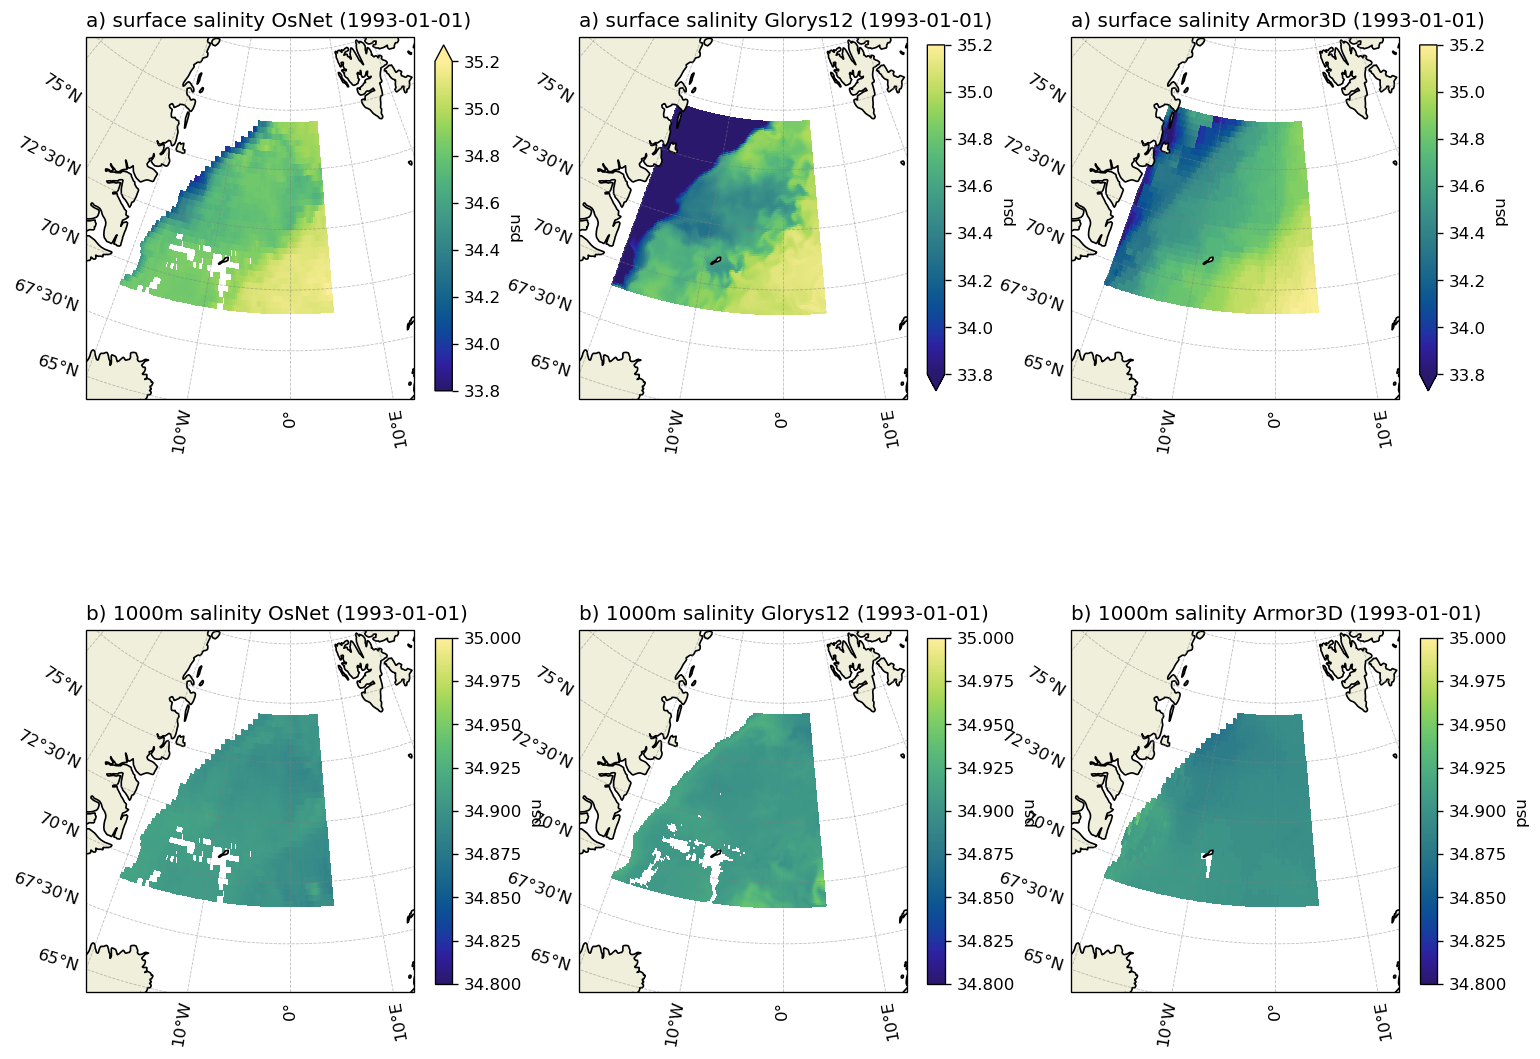

In [18]:
subplot_kw = {'projection': proj, 'extent': extent}

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 12), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)


# ------------------------------- Surface -----------------------


cb = ds['PSAL_predicted'].sel(time = t,DEPTH =  0).plot(ax=ax[0,0],center = False,  vmin=33.8, vmax = 35.2,
                  cmap=cmocean.cm.haline,
                  transform=ccrs.PlateCarree(),
                  cbar_kwargs={"shrink": 0.7,"label":'psu'})
ax[0,0].set_title('a) surface salinity OsNet (' + t + ')',loc = 'left')

ds_glorys_selected_area['so'].plot(ax=ax[0,1],center = False,  vmin=33.8, vmax = 35.2,
            cmap=cmocean.cm.haline,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"shrink": 0.7,"label":'psu'})
ax[0,1].set_title('a) surface salinity Glorys12 (' + t + ')',loc = 'left')

ds_Armor3D_selected_lon_area['so'].plot(ax=ax[0,2],center = False,  vmin=33.8, vmax = 35.2,
            cmap=cmocean.cm.haline,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"shrink": 0.7,"label":'psu'})
ax[0,2].set_title('a) surface salinity Armor3D (' + t + ')',loc = 'left')


        
# ------------------------------- 1000m -----------------------

ds['PSAL_predicted'].sel(time = t,DEPTH =  1000).plot(ax=ax[1,0],center = False,  vmin=34.8, vmax = 35,
                  cmap=cmocean.cm.haline,
                  transform=ccrs.PlateCarree(),
                  cbar_kwargs={"shrink": 0.7,"label":'psu'})
ax[1,0].set_title('b) 1000m salinity OsNet (' + t + ')',loc = 'left')

ds_glorys_selected_area_1000['so'].plot(ax=ax[1,1],center = False,  vmin=34.8, vmax = 35,
            cmap=cmocean.cm.haline,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"shrink": 0.7,"label":'psu'})
ax[1,1].set_title('b) 1000m salinity Glorys12 (' + t + ')',loc = 'left')

ds_Armor3D_selected_lon_area_1000['so'].plot(ax=ax[1,2],center = False,  vmin=34.8, vmax = 35,
            cmap=cmocean.cm.haline,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={"shrink": 0.7,"label":'psu'})
ax[1,2].set_title('b) 1000m salinity Armor3D (' + t + ')',loc = 'left')

for i in np.arange(2):
    for j in np.arange(3):
        ds_bat['bathymetry'].plot.contour(**kw,ax = ax[i,j])
        ax[i,j].add_feature(land_feature, edgecolor='black')
        gl = ax[i,j].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        
                
plt.show()
